<a href="https://colab.research.google.com/github/JamesVorder/ECE381V-FinalProject-GTZAN-KNN-RF/blob/main/MusicClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shared Classes And Functions (RUN ME FIRST)

In [ ]:
import pandas as pd
import numpy as np


def create_agg_columns(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
  df[f"mean_{col_name}"] = df[col_name].apply(lambda x: np.mean(x))
  df[f"var_{col_name}"] = df[col_name].apply(lambda x: np.var(x))
  df[f"ptp_{col_name}"] = df[col_name].apply(lambda x: np.ptp(x))
  return df

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


class ModelTrainer():

  def __init__(self, X=None, y=None):
    self.X = X
    self.y = y

  def prepare_train_test_split(self, ts: float = 0.2) -> None:
    """
    This function prepares a train-test split of the data so that we can train the model.
    param: ts: "test size" is the fraction of the data to set aside for testing.
    """
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = ts)

    scaler = MinMaxScaler().set_output(transform="pandas")

    self.X_train = scaler.fit_transform(X_train)
    self.X_test = scaler.transform(X_test)
    self.y_train = y_train
    self.y_test = y_test

  def select_features(self):
    clf= SVC(kernel="linear")
    rfe = RFECV(clf, step=1, n_jobs=10)

    rfe = rfe.fit(self.X_train, self.y_train)
    rfe.support_

    important_features = [feature for feature, enabled in zip(self.X_train.columns, rfe.support_) if enabled]

    # filter down to just important features
    self.X_train = self.X_train.filter(important_features)
    self.X_test = self.X_test.filter(important_features)
    self.important_features = important_features
    self.n_important_features = len(important_features)

  def train_and_validate(self, cleanup=False):
    clf = GridSearchCV(
      KNeighborsClassifier(),
        param_grid={
          "n_neighbors": [3, 5, 7, 9, 11]
        },
        n_jobs=10,
        return_train_score=True
      )

    clf.fit(self.X_train, self.y_train)
    self.mean_accuracy = clf.score(self.X_test, self.y_test)
    self.train_mean_accuracy = clf.score(self.X_train, self.y_train)
    self.best_params = clf.best_params_
    self.best_score = clf.best_score_
    self.classifier = clf

# Load GTZAN Dataset

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1SBDyW6-tp07U4ietCOKH8fozxLy_Tztj/view?usp=drive_link -O gtzan.zip

Downloading...
From (original): https://drive.google.com/uc?id=1SBDyW6-tp07U4ietCOKH8fozxLy_Tztj
From (redirected): https://drive.google.com/uc?id=1SBDyW6-tp07U4ietCOKH8fozxLy_Tztj&confirm=t&uuid=b373fd23-30a0-4430-bc5f-224d6cdd132c
To: /content/gtzan.zip
100% 1.30G/1.30G [00:13<00:00, 94.4MB/s]


In [ ]:
!unzip ./gtzan.zip

In [ ]:
# TODO: Replace this file with one that isn't corrupted
!rm ./Data/genres_original/jazz/jazz.00054.wav

In [ ]:
!pip install setuptools librosa

# GTZAN Feature Extraction

In [ ]:
import os
import pandas as pd

DATADIR = "Data"
AUDIODIR = os.path.join(DATADIR, "genres_original")

features_3_file = "features_3_sec.csv"

features_df = pd.read_csv(os.path.join(DATADIR, features_3_file))

In [ ]:
import librosa
import pandas as pd
from librosa import feature as F

files = list()
for genre in os.listdir(AUDIODIR):
  files += os.listdir(os.path.join(AUDIODIR, genre))

features_df = pd.DataFrame()
features_df["file"] = files

def extract_genre(filename: str) -> str:
  return filename.split(".", 1)[0]

features_df["genre"] = features_df["file"].apply(extract_genre)

def load_file_by_name(filename: str) -> tuple:
  return librosa.core.load(
    os.path.join(AUDIODIR, extract_genre(filename), filename),
    sr=22050,  # play with sr for fuzzy spectrogram
    mono=False,
    res_type="soxr_vhq",
  )


features_df["y"] = features_df["file"].apply(lambda x: load_file_by_name(x)[0])
features_df["sr"] = features_df["file"].apply(lambda x: load_file_by_name(x)[1])

In [ ]:
# https://librosa.org/doc/0.10.1/feature.html
features_df["chroma_stft"] = features_df.apply(lambda x: F.chroma_stft(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "chroma_stft")

In [ ]:
features_df["zero_crossing_rate"] = features_df.apply(lambda x: F.zero_crossing_rate(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "zero_crossing_rate")

In [ ]:
features_df["mfcc"] = features_df.apply(lambda x: F.mfcc(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "mfcc")

In [ ]:
features_df["spectral_centroid"] = features_df.apply(lambda x: F.spectral_centroid(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_centroid")

In [ ]:
features_df["spectral_bandwidth"] = features_df.apply(lambda x: F.spectral_bandwidth(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_bandwidth")

In [ ]:
features_df["spectral_contrast"] = features_df.apply(lambda x: F.spectral_contrast(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_contrast")

In [ ]:
features_df["spectral_flatness"] = features_df.apply(lambda x: F.spectral_flatness(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "spectral_flatness")

In [ ]:
features_df["spectral_rolloff"] = features_df.apply(lambda x: F.spectral_rolloff(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_rolloff")

In [ ]:
features_df["tempo"] = features_df.apply(lambda x: F.tempo(y=x.y, sr=x.sr, aggregate=None), axis=1)
features_df = create_agg_columns(features_df, "tempo")

In [ ]:
from librosa.effects import harmonic

features_df["harmonic"] = features_df.apply(lambda x: harmonic(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "harmonic")

In [ ]:
from librosa.effects import percussive

features_df["percussive"] = features_df.apply(lambda x: percussive(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "percussive")

In [ ]:
features_df.columns

Index(['file', 'genre', 'y', 'sr', 'chroma_stft', 'mean_chroma_stft',
       'var_chroma_stft', 'ptp_chroma_stft', 'zero_crossing_rate',
       'mean_zero_crossing_rate', 'var_zero_crossing_rate',
       'ptp_zero_crossing_rate', 'mfcc', 'mean_mfcc', 'var_mfcc', 'ptp_mfcc',
       'spectral_centroid', 'mean_spectral_centroid', 'var_spectral_centroid',
       'ptp_spectral_centroid', 'spectral_bandwidth',
       'mean_spectral_bandwidth', 'var_spectral_bandwidth',
       'ptp_spectral_bandwidth', 'spectral_contrast', 'mean_spectral_contrast',
       'var_spectral_contrast', 'ptp_spectral_contrast', 'spectral_flatness',
       'mean_spectral_flatness', 'var_spectral_flatness',
       'ptp_spectral_flatness', 'spectral_rolloff', 'mean_spectral_rolloff',
       'var_spectral_rolloff', 'ptp_spectral_rolloff', 'tempo', 'mean_tempo',
       'var_tempo', 'ptp_tempo', 'harmonic', 'mean_harmonic', 'var_harmonic',
       'ptp_harmonic', 'percussive', 'mean_percussive', 'var_percussive',
       'p

In [ ]:
features_df.to_csv("./features_jmv.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# copy the file from the Colab VM to Google Drive
!cp './features_jmv.csv' /content/gdrive/MyDrive/

Mounted at /content/gdrive


# KNN Feature Selection

## Get X and y

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/gdrive/MyDrive/features_jmv.csv ./features_dl.csv

In [ ]:
# copy the file from the Colab VM to Google Drive
!gdown --fuzzy https://drive.google.com/file/d/1VHD-8anhBlomQ782T6kAGWezWiitby9O/view?usp=drive_link -O features_dl.csv

Downloading...
From: https://drive.google.com/uc?id=1VHD-8anhBlomQ782T6kAGWezWiitby9O
To: /content/features_dl.csv
100% 2.79M/2.79M [00:00<00:00, 180MB/s]


In [ ]:
# Let's do recursive feature elimination using some estimator.
# Then, we can feed those features into KNN algo to actually classify things

import pandas as pd
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

features_df = pd.read_csv("./features_dl.csv")

X = features_df.drop(columns=["Unnamed: 0", "file", "genre", "y", "sr", "chroma_stft", "zero_crossing_rate",
                              "mfcc", "spectral_centroid", "spectral_bandwidth",
                              "spectral_contrast", "spectral_flatness", "spectral_rolloff",
                              "tempo", "harmonic", "percussive"])
y = features_df["genre"]

le = LabelEncoder()
le.fit(y.unique())
y = le.transform(y)

# KNN Hyper-Parameter Tuning

Now, let's close in on the best parameters with some cross validation, and see how well we can get this to perform.

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
scaler = MinMaxScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV


clf= SVC(kernel="linear")
rfe = RFECV(clf, step=1, n_jobs=10)

rfe = rfe.fit(X_train, y_train)
rfe.support_

important_features = [feature for feature, enabled in zip(X_train.columns, rfe.support_) if enabled]
print(f"len(important_features) = {len(important_features)}")
print(f"important_features = {important_features}")

# filter down to just important features
X_train = X_train.filter(important_features)
X_test = X_test.filter(important_features)

len(important_features) = 32
important_features = ['mean_chroma_stft', 'var_chroma_stft', 'ptp_chroma_stft', 'mean_zero_crossing_rate', 'var_zero_crossing_rate', 'ptp_zero_crossing_rate', 'mean_mfcc', 'var_mfcc', 'ptp_mfcc', 'mean_spectral_centroid', 'var_spectral_centroid', 'ptp_spectral_centroid', 'mean_spectral_bandwidth', 'var_spectral_bandwidth', 'ptp_spectral_bandwidth', 'mean_spectral_contrast', 'var_spectral_contrast', 'ptp_spectral_contrast', 'mean_spectral_flatness', 'ptp_spectral_flatness', 'mean_spectral_rolloff', 'var_spectral_rolloff', 'ptp_spectral_rolloff', 'mean_tempo', 'var_tempo', 'ptp_tempo', 'mean_harmonic', 'var_harmonic', 'ptp_harmonic', 'mean_percussive', 'var_percussive', 'ptp_percussive']


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


clf = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={
      "n_neighbors": [1, 3, 5, 7, 9, 11],
      "p": [1, 2, 3, 4, 5]
    },
    n_jobs=10,
    return_train_score=True
  )

clf.fit(X_train, y_train)
mean_accuracy = clf.score(X_test, y_test)
train_mean_accuracy = clf.score(X_train, y_train)

print(f"train mean_accuracy = {train_mean_accuracy}")
print(f"mean_accuracy = {mean_accuracy}")
print(f"best_params_ = {clf.best_params_}")
print(f"best_score_ = {clf.best_score_}")

train mean_accuracy = 0.7684605757196495
mean_accuracy = 0.625
best_params_ = {'n_neighbors': 5, 'p': 1}
best_score_ = 0.6307389937106918


# Train KNN 100 Times

* What is the distribution of scores?
* number of features selected?
* n_neighbors selected

In [ ]:

trainers = list()

for _ in range(100):
  trainer = ModelTrainer(X, y)
  trainer.prepare_train_test_split(ts=0.3)
  trainer.select_features()
  trainer.train_and_validate()
  trainers.append(trainer)

# for i, trainer in enumerate(trainers):
#   print(f"Trainer {i}... fight!")
#   print(f"train mean_accuracy = {trainer.train_mean_accuracy}")
#   print(f"mean_accuracy = {trainer.mean_accuracy}")
#   print(f"best_params = {trainer.best_params}")
#   print(f"best_score = {trainer.best_score}")
#   print(f"n_important_features = {trainer.n_important_features}")
#   print(f"important_features = {trainer.important_features}")

In [ ]:
winner = sorted(trainers, key=lambda x: x.mean_accuracy, reverse=True)[0]
print(f"Out of {len(trainers)} trainers...")
print(f"The winning accuracy is.... {winner.mean_accuracy}!")
print(f"params = {winner.best_params}")
print(f"n_important_features = {winner.n_important_features}")
print(f"important_features = {winner.important_features}")

Out of 100 trainers...
The winning accuracy is.... 0.6433333333333333!
params = {'n_neighbors': 7}
n_important_features = 20
important_features = ['mean_chroma_stft', 'var_chroma_stft', 'mean_zero_crossing_rate', 'ptp_zero_crossing_rate', 'mean_mfcc', 'ptp_mfcc', 'ptp_spectral_centroid', 'mean_spectral_bandwidth', 'ptp_spectral_bandwidth', 'mean_spectral_contrast', 'var_spectral_contrast', 'ptp_spectral_contrast', 'ptp_spectral_flatness', 'ptp_spectral_rolloff', 'mean_tempo', 'ptp_tempo', 'ptp_harmonic', 'mean_percussive', 'var_percussive', 'ptp_percussive']


# KNN Figures For The Paper

Let's generate some figures for the paper!


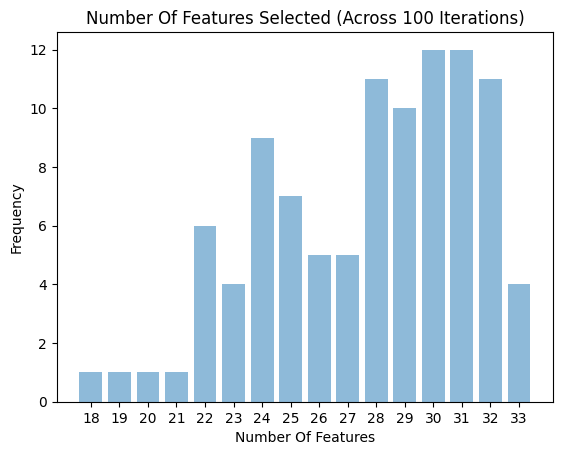

In [ ]:
# TODO: distribution of number of important features
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

n_features_list = [trainer.n_important_features for trainer in trainers]
n_features, n_features_freq = np.unique(n_features_list, return_counts=True)


objects = n_features
y_pos = np.arange(len(n_features))
performance = n_features_freq

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.xlabel('Number Of Features')
plt.title('Number Of Features Selected (Across 100 Iterations)')

plt.show()

{'mean_chroma_stft': 100, 'var_chroma_stft': 100, 'mean_zero_crossing_rate': 100, 'ptp_zero_crossing_rate': 100, 'mean_mfcc': 100, 'ptp_mfcc': 100, 'ptp_spectral_centroid': 100, 'mean_spectral_bandwidth': 100, 'mean_spectral_contrast': 100, 'var_spectral_contrast': 100, 'ptp_spectral_contrast': 100, 'ptp_spectral_rolloff': 100, 'mean_tempo': 100, 'ptp_tempo': 100, 'ptp_harmonic': 100, 'var_percussive': 100, 'ptp_percussive': 100, 'ptp_spectral_flatness': 99, 'mean_spectral_rolloff': 98, 'ptp_spectral_bandwidth': 97, 'ptp_chroma_stft': 93, 'mean_percussive': 90, 'var_spectral_centroid': 83, 'var_spectral_rolloff': 82, 'mean_spectral_centroid': 80, 'var_tempo': 78, 'var_harmonic': 68, 'var_zero_crossing_rate': 66, 'var_mfcc': 52, 'var_spectral_bandwidth': 37, 'mean_spectral_flatness': 21, 'mean_harmonic': 21, 'var_spectral_flatness': 7}


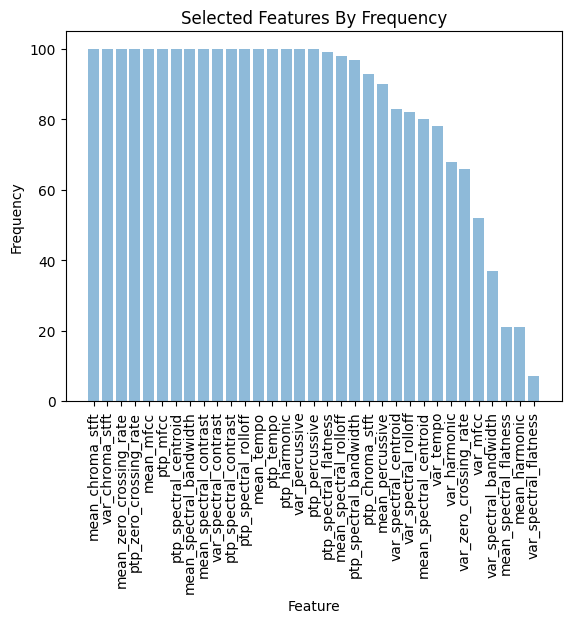

In [ ]:
# TODO: list top 5 most frequently selected important features
from collections import Counter


selected_features_all = list()
for trainer in trainers:
  selected_features_all += trainer.important_features

frequencies = Counter(selected_features_all)
frequencies = dict(sorted(frequencies.items(), key=lambda x: x[1], reverse=True))
print(frequencies)

objects = frequencies.keys()
y_pos = np.arange(len(frequencies))
performance = frequencies.values()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.xlabel('Feature')
plt.title('Selected Features By Frequency')

plt.show()

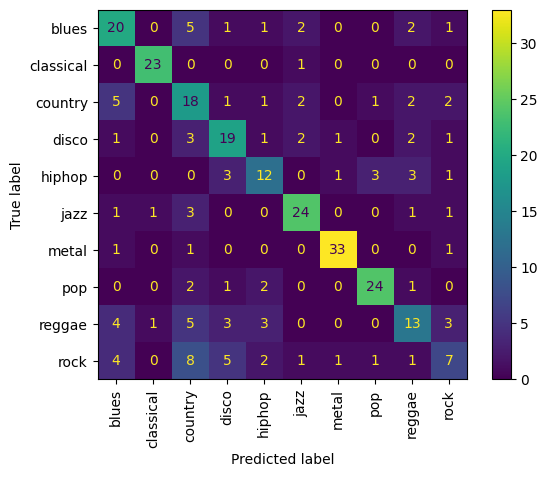

In [ ]:
# TODO: confusion matrix of best-performing model
# do prediction on that trainer's test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(winner.y_test, winner.classifier.predict(winner.X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation="vertical")

# Save KNN Results In GDrive

That way I can pick it back up later to run on the unseen data, replicate results, etc.

In [ ]:
import pickle

with open('winner.pkl', 'wb') as o:
    pickle.dump(winner, o, pickle.HIGHEST_PROTOCOL)

with open('trainers.pkl', 'wb') as o:
  pickle.dump(trainers, o, pickle.HIGHEST_PROTOCOL)

PicklingError: Can't pickle <class '__main__.ModelTrainer'>: it's not the same object as __main__.ModelTrainer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp './winner.pkl' "/content/gdrive/MyDrive/Machine Learning Final Project/"
!cp './trainers.pkl' "/content/gdrive/MyDrive/Machine Learning Final Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Random Forest Model
This is the final model that was used for training and testing

# Random Forest Hyperparameter Tuning
The following code shows the Grid Search that was done to tune the hyperparameters of the random forest model. These parameters were chosen based on previous research.

Optimal number of features: 25


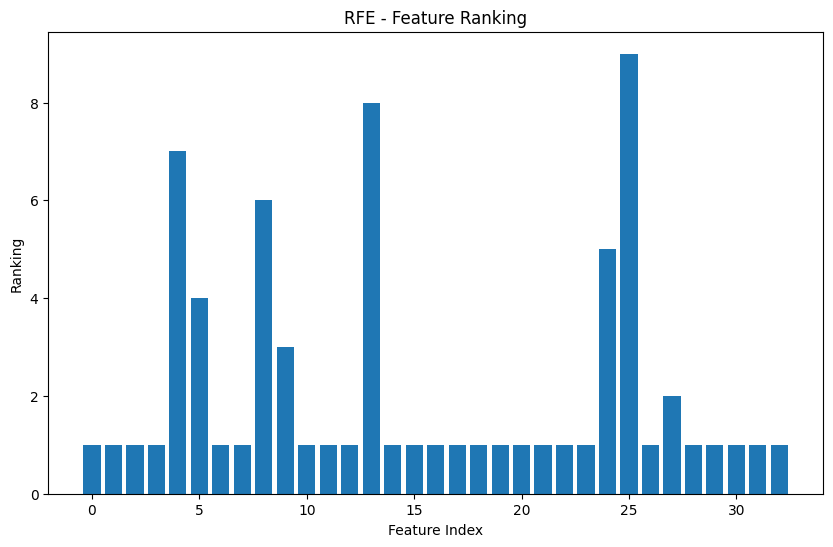

Selected Features: ['mean_chroma_stft', 'var_chroma_stft', 'ptp_chroma_stft', 'mean_zero_crossing_rate', 'mean_mfcc', 'var_mfcc', 'var_spectral_centroid', 'ptp_spectral_centroid', 'mean_spectral_bandwidth', 'ptp_spectral_bandwidth', 'mean_spectral_contrast', 'var_spectral_contrast', 'ptp_spectral_contrast', 'mean_spectral_flatness', 'var_spectral_flatness', 'ptp_spectral_flatness', 'mean_spectral_rolloff', 'var_spectral_rolloff', 'ptp_spectral_rolloff', 'ptp_tempo', 'var_harmonic', 'ptp_harmonic', 'mean_percussive', 'var_percussive', 'ptp_percussive']
Accuracy on the Test Set: 0.605
Optimal number of features: 32


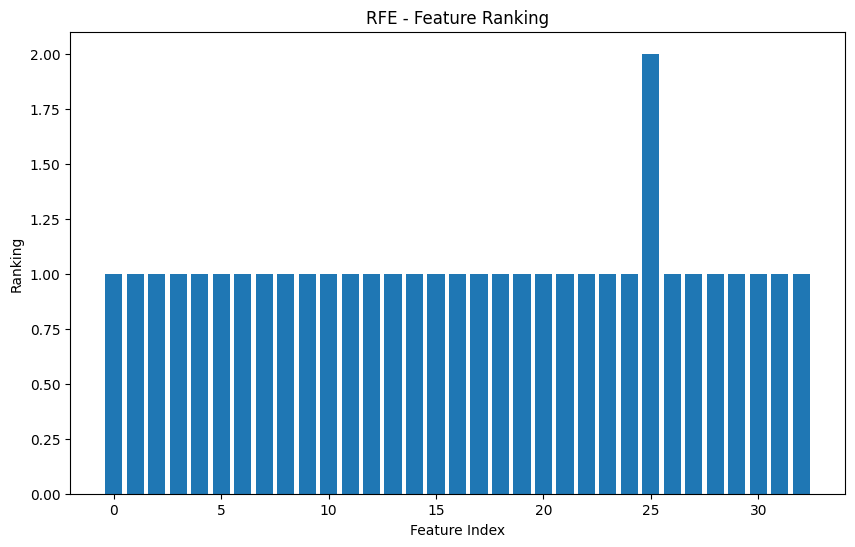

Selected Features: ['mean_chroma_stft', 'var_chroma_stft', 'ptp_chroma_stft', 'mean_zero_crossing_rate', 'var_zero_crossing_rate', 'ptp_zero_crossing_rate', 'mean_mfcc', 'var_mfcc', 'ptp_mfcc', 'mean_spectral_centroid', 'var_spectral_centroid', 'ptp_spectral_centroid', 'mean_spectral_bandwidth', 'var_spectral_bandwidth', 'ptp_spectral_bandwidth', 'mean_spectral_contrast', 'var_spectral_contrast', 'ptp_spectral_contrast', 'mean_spectral_flatness', 'var_spectral_flatness', 'ptp_spectral_flatness', 'mean_spectral_rolloff', 'var_spectral_rolloff', 'ptp_spectral_rolloff', 'mean_tempo', 'ptp_tempo', 'mean_harmonic', 'var_harmonic', 'ptp_harmonic', 'mean_percussive', 'var_percussive', 'ptp_percussive']
Accuracy on the Test Set: 0.67
Optimal number of features: 32


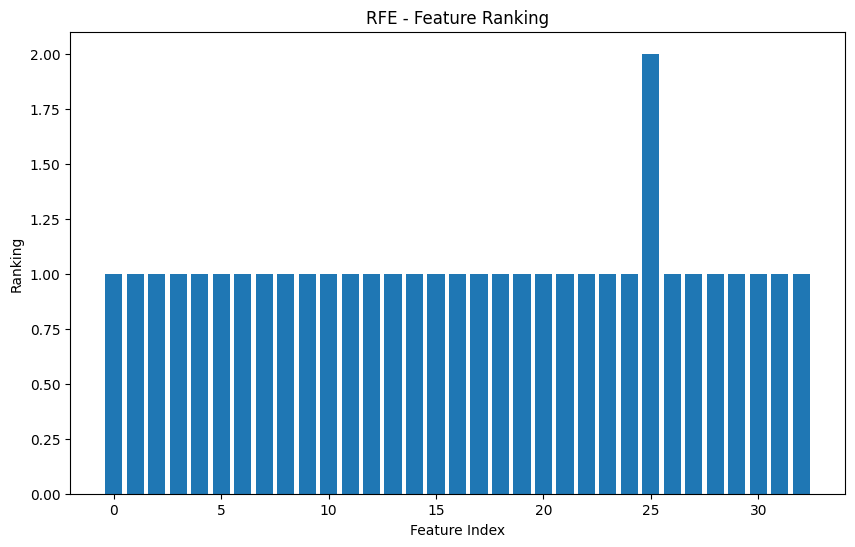

Selected Features: ['mean_chroma_stft', 'var_chroma_stft', 'ptp_chroma_stft', 'mean_zero_crossing_rate', 'var_zero_crossing_rate', 'ptp_zero_crossing_rate', 'mean_mfcc', 'var_mfcc', 'ptp_mfcc', 'mean_spectral_centroid', 'var_spectral_centroid', 'ptp_spectral_centroid', 'mean_spectral_bandwidth', 'var_spectral_bandwidth', 'ptp_spectral_bandwidth', 'mean_spectral_contrast', 'var_spectral_contrast', 'ptp_spectral_contrast', 'mean_spectral_flatness', 'var_spectral_flatness', 'ptp_spectral_flatness', 'mean_spectral_rolloff', 'var_spectral_rolloff', 'ptp_spectral_rolloff', 'mean_tempo', 'ptp_tempo', 'mean_harmonic', 'var_harmonic', 'ptp_harmonic', 'mean_percussive', 'var_percussive', 'ptp_percussive']
Accuracy on the Test Set: 0.675


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

num_estimators = [64, 100, 168]

for num in num_estimators:
  cv = StratifiedKFold(5)
  clf = RandomForestClassifier(n_estimators=num, random_state=42)
  rfecv = RFECV(
      estimator=clf,
      step=1,
      cv=cv,
      scoring="accuracy",
      min_features_to_select=1,
      n_jobs=2,
  )
  rfecv.fit(X, y)

  print(f"Optimal number of features: {rfecv.n_features_}")

  rfe = RFE(clf, n_features_to_select=rfecv.n_features_, step=1)
  rfe.fit(X_train, y_train)

  feature_ranking = rfe.ranking_

  # Get the selected features
  selected_features = np.where(feature_ranking == 1)[0]

  important_features = [feature for feature, enabled in zip(X.columns, rfe.support_) if enabled]
  X.filter(important_features).head()

  # Visualize the feature ranking
  plt.figure(figsize=(10, 6))
  plt.title("RFE - Feature Ranking")
  plt.xlabel("Feature Index")
  plt.ylabel("Ranking")
  plt.bar(range(len(feature_ranking)), feature_ranking)
  plt.show()

  # Print the selected features
  print("Selected Features:", important_features)

  # Train the final model using the selected features
  clf.fit(X_train[:, selected_features], y_train)

  # Evaluate the model on the test set
  accuracy = clf.score(X_test[:, selected_features], y_test)
  print("Accuracy on the Test Set:", accuracy)


In [ ]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
import warnings

warnings.filterwarnings('ignore')

rf_params = {
    'criterion' :['entropy', 'gini'],
    'max_depth': [None, 20, 60, 80],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(n_estimators=168, random_state=42),
                              param_grid=rf_params, cv=5)
rf_grid_search.fit(X_train, y_train)
print(f"Optimal Hyperparameters: {rf_grid_search.best_params_}")

Optimal Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


# Random Forest Tuned Model + Results

In [ ]:
clf = RandomForestClassifier(n_estimators=168, criterion='entropy', min_samples_leaf=1, min_samples_split=2, max_depth=None, max_features='auto', random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.625


Final Confusion Matrix

In [ ]:
rf_final_clf = clf

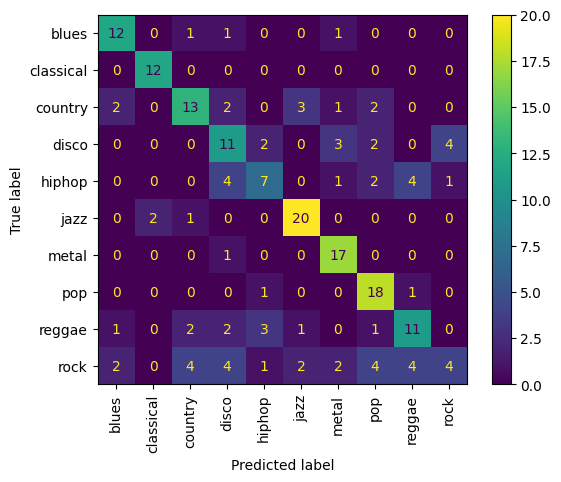

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_final_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation="vertical")

# Load KNN Trainers + Winner From GDrive

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/18hcwlJYfTIY5tK-9cl9dVMG41XRoQkDt/view?usp=drive_link -O winner.pkl
!gdown --fuzzy https://drive.google.com/file/d/1-8kRlseORgBvQKJkJG0f6l7_CWFUgp-i/view?usp=sharing -O trainers.pkl

Downloading...
From: https://drive.google.com/uc?id=18hcwlJYfTIY5tK-9cl9dVMG41XRoQkDt
To: /content/winner.pkl
100% 611k/611k [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8kRlseORgBvQKJkJG0f6l7_CWFUgp-i
To: /content/trainers.pkl
100% 39.7M/39.7M [00:00<00:00, 105MB/s]


In [ ]:
import pickle


trainers = list()
winner = ModelTrainer()

with open('trainers.pkl', 'rb') as i:
  trainers = pickle.load(i)

with open('winner.pkl', 'rb') as i:
  winner = pickle.load(i)

# Load Hand-Picked FMA Data

Let's try to work with some hand-pulled FMA samples. The dataset above was near-impossible to work with. It honestly might be easier just to use a folder structure that I've created on my own as a jumping off point.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/16bGz_Pliv4ncTpHk8xNKJQ5_Yg9XiZFL/view?usp=sharing -O 'fma_jmv.zip'

Downloading...
From (original): https://drive.google.com/uc?id=16bGz_Pliv4ncTpHk8xNKJQ5_Yg9XiZFL
From (redirected): https://drive.google.com/uc?id=16bGz_Pliv4ncTpHk8xNKJQ5_Yg9XiZFL&confirm=t&uuid=30c99d07-4c9c-404b-a04e-9aa8cdaad6c1
To: /content/fma_jmv.zip
100% 108M/108M [00:00<00:00, 152MB/s] 


In [ ]:
!unzip -q fma_jmv.zip

In [ ]:
import os
import json
import pickle
import dask.dataframe as dd
import librosa
import pandas as pd
from librosa import feature as F

files = list()
AUDIODIR = os.path.join("fma_dumb_pull")

samples = list(list()) # one row per sample, multiple columns per sample
# genre, filename, y

for dir in os.listdir(AUDIODIR):
  target = os.path.join(AUDIODIR, dir)
  if os.path.isdir(target):
    curr_genre = dir.split("/")[-1]
    for f in os.listdir(target):
      if f.endswith(".mp3"):
        y, sr = librosa.load(
            os.path.join(target, f), sr=22050, mono=False, res_type="soxr_vhq")
        samples.append([curr_genre, f, y, sr])

samples_df = pd.DataFrame(samples, columns=["genre", "filename", "y", "sr"])
features_df = samples_df.copy()

In [ ]:
# https://librosa.org/doc/0.10.1/feature.html
features_df["chroma_stft"] = features_df.apply(lambda x: F.chroma_stft(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "chroma_stft")
features_df.drop("chroma_stft", axis=1, inplace=True)

In [ ]:
features_df["zero_crossing_rate"] = features_df.apply(lambda x: F.zero_crossing_rate(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "zero_crossing_rate")
features_df.drop("zero_crossing_rate", axis=1, inplace=True)

In [ ]:
features_df["mfcc"] = features_df.apply(lambda x: F.mfcc(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "mfcc")
features_df.drop("mfcc", axis=1, inplace=True)

In [ ]:
features_df["spectral_centroid"] = features_df.apply(lambda x: F.spectral_centroid(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_centroid")
features_df.drop("spectral_centroid", axis=1, inplace=True)

In [ ]:
features_df["spectral_bandwidth"] = features_df.apply(lambda x: F.spectral_bandwidth(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_bandwidth")
features_df.drop("spectral_bandwidth", axis=1, inplace=True)

In [ ]:
features_df["spectral_contrast"] = features_df.apply(lambda x: F.spectral_contrast(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_contrast")
features_df.drop("spectral_contrast", axis=1, inplace=True)

In [ ]:
features_df["spectral_flatness"] = features_df.apply(lambda x: F.spectral_flatness(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "spectral_flatness")
features_df.drop("spectral_flatness", axis=1, inplace=True)

In [ ]:
features_df["spectral_rolloff"] = features_df.apply(lambda x: F.spectral_rolloff(y=x.y, sr=x.sr), axis=1)
features_df = create_agg_columns(features_df, "spectral_rolloff")
features_df.drop("spectral_rolloff", axis=1, inplace=True)

In [ ]:
features_df["tempo"] = features_df.apply(lambda x: F.tempo(y=x.y, sr=x.sr, aggregate=None), axis=1)
features_df = create_agg_columns(features_df, "tempo")
features_df.drop("tempo", axis=1, inplace=True)

In [ ]:
from librosa.effects import harmonic

features_df["harmonic"] = features_df.apply(lambda x: harmonic(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "harmonic")
features_df.drop("harmonic", axis=1, inplace=True)

In [ ]:
from librosa.effects import percussive

features_df["percussive"] = features_df.apply(lambda x: percussive(y=x.y), axis=1)
features_df = create_agg_columns(features_df, "percussive")
features_df.drop("percussive", axis=1, inplace=True)

In [ ]:
features_df.drop("y", axis=1, inplace=True)

In [ ]:
features_df.to_parquet("./fma_features_jmv.parquet")

# Run Winning KNN Model On FMA Data

In [ ]:
features_df = pd.read_parquet("./fma_features_jmv.parquet")
y_unseen = features_df["genre"]
y_unseen = le.transform(y_unseen)

X_unseen = features_df.filter(winner.classifier.feature_names_in_)
scaler = MinMaxScaler().set_output(transform="pandas")
X_unseen = scaler.fit_transform(X_unseen)

NameError: name 'winner' is not defined

In [ ]:
# TODO: confusion matrix of best-performing model
# do prediction on that trainer's test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(winner.classifier.score(X_unseen, y_unseen))
cm = confusion_matrix(y_unseen, winner.classifier.predict(X_unseen))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
  )
disp.plot(xticks_rotation="vertical")

NameError: name 'winner' is not defined

# Run Winning RF Model On FMA Data

In [ ]:
features_df = pd.read_parquet("./fma_features_jmv.parquet")
y_unseen = features_df["genre"]
y_unseen = le.transform(y_unseen)

X_unseen = features_df.drop(["genre", "filename", "sr"], axis=1)
scaler = MinMaxScaler().set_output(transform="pandas")
X_unseen = scaler.fit_transform(X_unseen)

0.3142857142857143


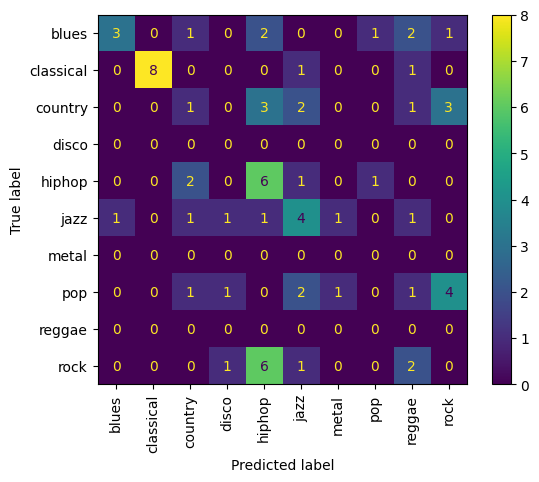

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_hat =rf_final_clf.predict(X_unseen)
print(rf_final_clf.score(X_unseen, y_unseen))
cm = confusion_matrix(y_unseen, y_hat)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
  )
disp.plot(xticks_rotation="vertical")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


rfc= RandomForestClassifier()
# rfc.fit(X,y)

rfe = RFE(rfc, n_features_to_select=5, step=1)

rfe = rfe.fit(X, y)
rfe.support_

important_features = [feature for feature, enabled in zip(X.columns, rfe.support_) if enabled]
X.filter(important_features).head()

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False])

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.filter(important_features), y, test_size = 0.2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
mean_accuracy = clf.score(X_test, y_test)

print(f"mean_accuracy = {mean_accuracy}")

mean_accuracy = 0.28
